# Lab 12 - Training Deep Convolutional Neural Network
- Kanyaluck Chimchome, 64070501003
- Chanidapa Chanama, 64070501090

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [128]:
# %pip install np_utils

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import np_utils
from keras.layers import MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['sparse_categorical_accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_sparse_categorical_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# 1. Import data

In [132]:
#  !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
#  !unzip -qq Cat_Dog_data.zip

In [7]:
c_d_train = tf.keras.utils.image_dataset_from_directory(
    directory="./Cat_Dog_data/train",
    labels="inferred",
    # label_mode="binary",
    seed=123,
    validation_split=0.1,
    subset="training",
)

Found 22500 files belonging to 2 classes.
Using 20250 files for training.


In [9]:
c_d_validation = tf.keras.utils.image_dataset_from_directory(
    directory="./Cat_Dog_data/train",
    labels="inferred",
    # label_mode="binary",
    seed=123,
    validation_split=0.1,
    subset="validation",
)

Found 22500 files belonging to 2 classes.
Using 2250 files for validation.


In [8]:
c_d_test = keras.utils.image_dataset_from_directory(
    directory="./Cat_Dog_data/test",
    labels="inferred",
    label_mode="binary",
)

Found 2500 files belonging to 2 classes.


In [136]:
class_names = c_d_train.class_names
print(class_names)

['cat', 'dog']


In [137]:
for image_batch, labels_batch in c_d_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


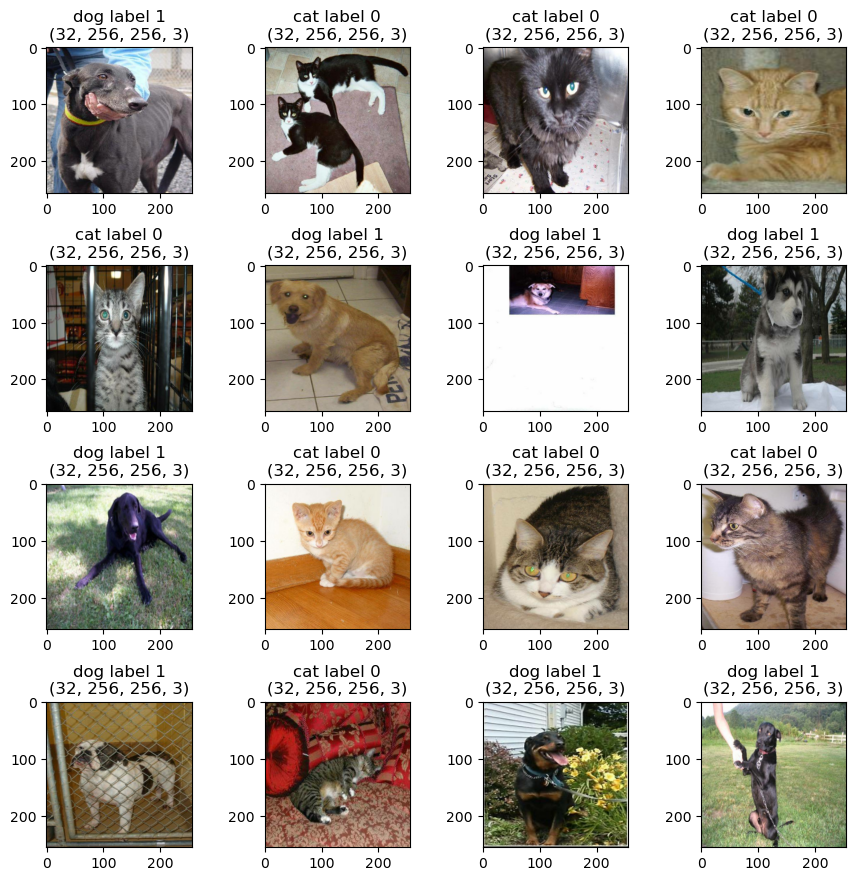

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in c_d_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])] + " label " + str(int(labels[i])) + "\n" + str(images.shape))
    plt.axis("on")

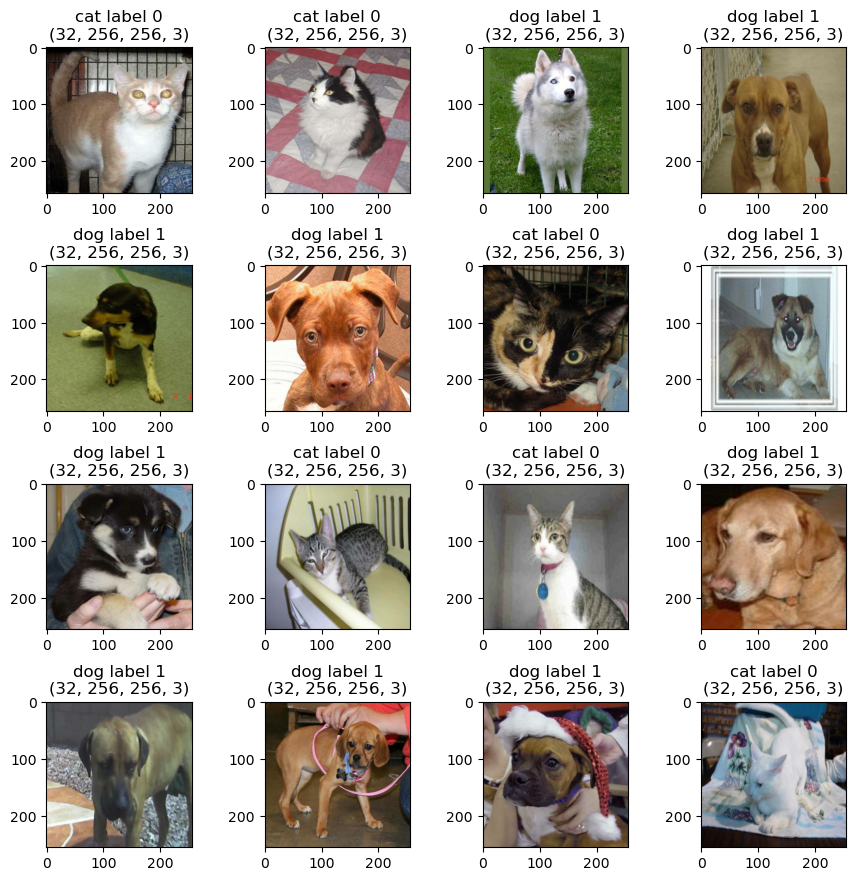

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in c_d_test.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])] + " label " + str(int(labels[i])) + "\n" + str(images.shape))
    plt.axis("on")

# 2. Prepocessing data

In [10]:
BATCH_SIZE = 32

In [141]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = c_d_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = c_d_validation.cache().prefetch(buffer_size=AUTOTUNE)

In [142]:
image_batch, labels_batch = next(iter(c_d_train))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

8.807678 255.0


In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = c_d_train.map(lambda x, y: (normalization_layer(x), int(y)))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
for image_batch, labels_batch in c_d_train:
  data_shape = image_batch.shape
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break

(32, 256, 256, 3)
(32,)
tf.Tensor([1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0], shape=(32,), dtype=int32)


In [14]:
IMG_WIDTH = data_shape[1]
IMG_HEIGHT = data_shape[2]
CHANNEL = data_shape[3]
print("Image\n  Width: " + str(IMG_WIDTH) + "\n  Height: " + str(IMG_HEIGHT) + "\n  Channel: " + str(CHANNEL))

Image
  Width: 256
  Height: 256
  Channel: 3


# 3. Build a convolutional neural network

In [164]:
cnn = models.Sequential()

# data augmentation
cnn.add(layers.RandomFlip("horizontal", input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL)))
cnn.add(layers.RandomRotation(0.1))
cnn.add(layers.RandomZoom(0.1))
cnn.add(layers.RandomContrast(0.1))

cnn.add(layers.Conv2D(filters=16,
                      kernel_size=3,
                      activation = 'relu',
                      kernel_initializer='he_normal',
                      padding='same',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=16,
                      kernel_size=3,
                      activation = 'relu',
                      kernel_initializer='he_normal',
                      padding='same',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      kernel_initializer='he_normal',
                      activation = 'relu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=128,
                      kernel_size=3,
                      kernel_initializer='he_normal',
                      activation = 'relu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Flatten())
# cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dense(512,activation='relu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Dense(2,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer="adam",
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.save('baseline_model.h5') #save weight (memory the weight for reuse)
cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_5 (RandomFlip)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom_4 (RandomZoom)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_4 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 128, 128, 16)    

# 4. Training CNN Model

In [165]:
history = cnn.fit(normalized_ds, epochs=10,validation_data=c_d_validation,verbose=1)
cnn.save('baseline_model_10.h5')

Epoch 1/10
633/633 [==============================] - 87s 131ms/step - loss: 2.1692 - sparse_categorical_accuracy: 0.6486 - val_loss: 57.0226 - val_sparse_categorical_accuracy: 0.6124
Epoch 2/10
633/633 [==============================] - 80s 127ms/step - loss: 0.5607 - sparse_categorical_accuracy: 0.7163 - val_loss: 85.8711 - val_sparse_categorical_accuracy: 0.6662
Epoch 3/10
633/633 [==============================] - 81s 128ms/step - loss: 0.5221 - sparse_categorical_accuracy: 0.7462 - val_loss: 96.4878 - val_sparse_categorical_accuracy: 0.6804
Epoch 4/10
633/633 [==============================] - 81s 128ms/step - loss: 0.4830 - sparse_categorical_accuracy: 0.7705 - val_loss: 73.8981 - val_sparse_categorical_accuracy: 0.7142
Epoch 5/10
633/633 [==============================] - 81s 128ms/step - loss: 0.4609 - sparse_categorical_accuracy: 0.7829 - val_loss: 64.9273 - val_sparse_categorical_accuracy: 0.6742
Epoch 6/10
633/633 [==============================] - 81s 129ms/step - loss: 0.4

Last train accuracy: 0.8241481184959412
Last validation accuracy: 0.7248888611793518


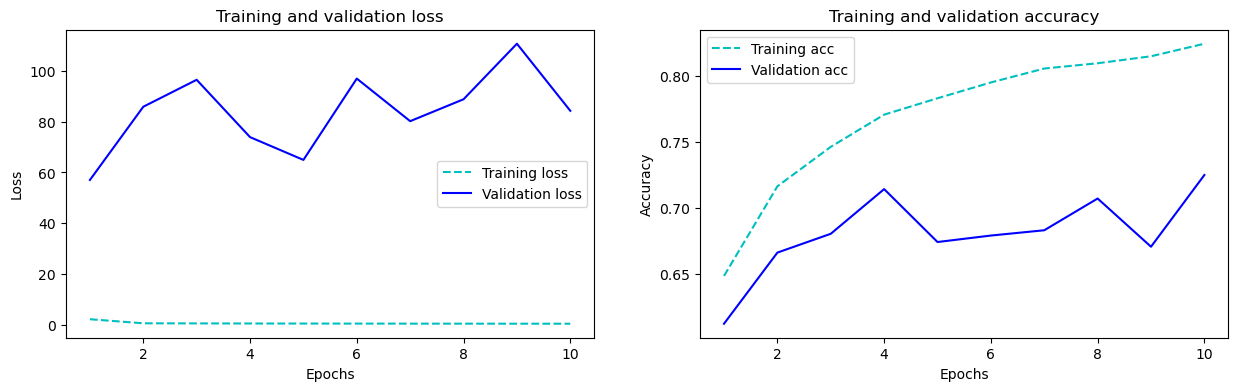

In [166]:
show_result(history)

Because the accuracy did not reach 0.9, we would try to use pretrain model to make the model better.

## Optimize by pre-trained VGG16 model

In [176]:
from keras.applications.vgg16 import VGG16

INPUT_SIZE = 256
vgg16 = VGG16(include_top = False, weights = 'imagenet',input_shape=(INPUT_SIZE,INPUT_SIZE,3))

for layer in vgg16.layers:
    layer.trainable=False

In [207]:
from keras.models import Model

input_layer = vgg16.input
output_layer= vgg16(input_layer)
last_layer = layers.Flatten(name='flatten')(output_layer)
last_layer = layers.Dense(256,activation='relu',name='fully_connect_1')(last_layer)
last_layer = layers.Dense(2,activation ='softmax')(last_layer)
model = Model(inputs=input_layer, outputs = last_layer)

model.compile(optimizer="adam",
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])

model.save('pretrained_vgg16.h5') #save weight (memory the weight for reuse)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
fully_connect_1 (Dense)      (None, 256)               8388864   
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 23,104,066
Trainable params: 8,389,378
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
import keras

model = keras.models.load_model('pretrained_vgg16.h5')
history_vgg16 = model.fit(normalized_ds, epochs=10, validation_data=c_d_validation, verbose=1)
model.save('pretrained_vgg16_10.h5')

Epoch 1/10
633/633 [==============================] - 91s 132ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.8979 - val_loss: 5.7447 - val_sparse_categorical_accuracy: 0.9347
Epoch 2/10
633/633 [==============================] - 80s 127ms/step - loss: 0.1190 - sparse_categorical_accuracy: 0.9516 - val_loss: 5.8960 - val_sparse_categorical_accuracy: 0.9418
Epoch 3/10
633/633 [==============================] - 79s 125ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9660 - val_loss: 8.0140 - val_sparse_categorical_accuracy: 0.9387
Epoch 4/10
633/633 [==============================] - 80s 126ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9763 - val_loss: 9.8469 - val_sparse_categorical_accuracy: 0.9400
Epoch 5/10
633/633 [==============================] - 80s 126ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9789 - val_loss: 14.4846 - val_sparse_categorical_accuracy: 0.9249
Epoch 6/10
633/633 [==============================] - 80s 126ms/step - loss: 0.0396 

Last train accuracy: 0.9923456907272339
Last validation accuracy: 0.9315555691719055


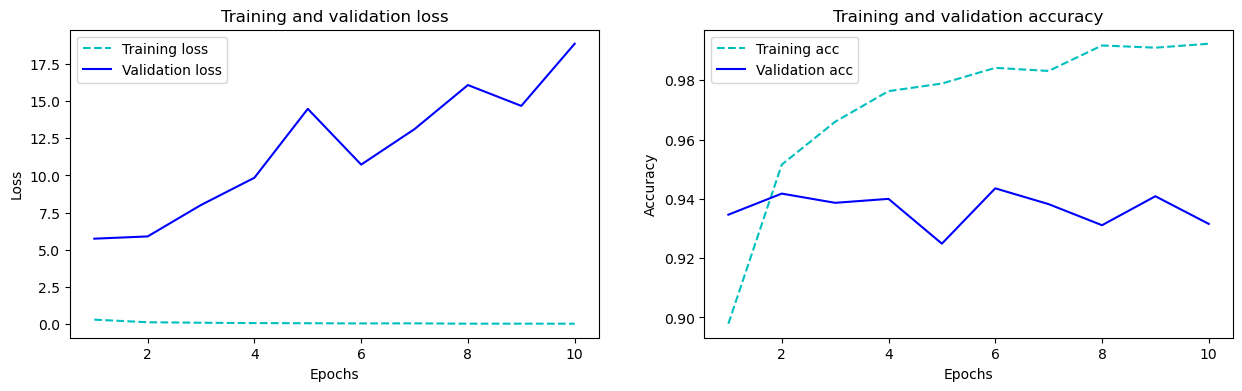

In [16]:
show_result(history_vgg16)

# 5. Evaluate Model

In [17]:
images_test = []
labels_test = []

for image, labels in c_d_test:
  images_test.append(image)
  labels_test.append(labels)

images_test = np.concatenate(images_test)
labels_test = np.concatenate(labels_test)


In [18]:
pred_class = evaluation_report(model, images_test, labels_test)

[[1102 1398]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      2500
           1       0.00      0.00      0.00         0

    accuracy                           0.44      2500
   macro avg       0.50      0.22      0.31      2500
weighted avg       1.00      0.44      0.61      2500

Loss: 19.015552520751953 Accuracy: 0.9319999814033508


c:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test with external image

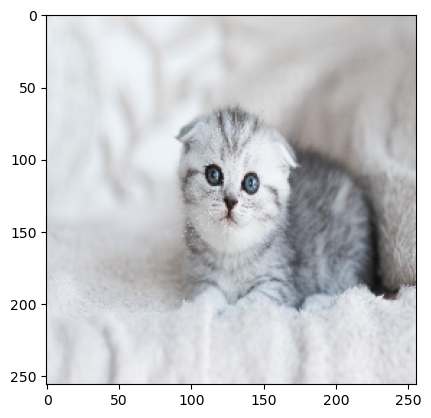

In [23]:
test_img_1 = keras.preprocessing.image.load_img("cat_test.png", target_size=(256, 256))
plt.imshow(test_img_1)
plt.show()

In [35]:
# Preprocess data
img_tensor_1 = np.expand_dims(keras.preprocessing.image.img_to_array(test_img_1),axis=0)/255.

# Feed into activation model to get an activation value
prediction_model = models.load_model('pretrained_vgg16_10.h5')
prediction = prediction_model.predict(img_tensor_1)
c_d_test.class_names[np.argmax(prediction)]

'cat'

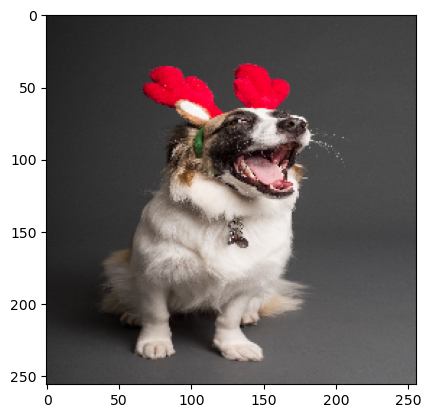

In [36]:
test_img_2 = keras.preprocessing.image.load_img("dog_test_christmas.jpg", target_size=(256, 256))
plt.imshow(test_img_2)
plt.show()

In [40]:
# Preprocess data
img_tensor_2 = np.expand_dims(keras.preprocessing.image.img_to_array(test_img_2),axis=0)/255.

# Feed into activation model to get an activation value
prediction_model_2 = models.load_model('pretrained_vgg16_10.h5')
prediction_2 = prediction_model_2.predict(img_tensor_2)
c_d_test.class_names[np.argmax(prediction_2)]

'dog'

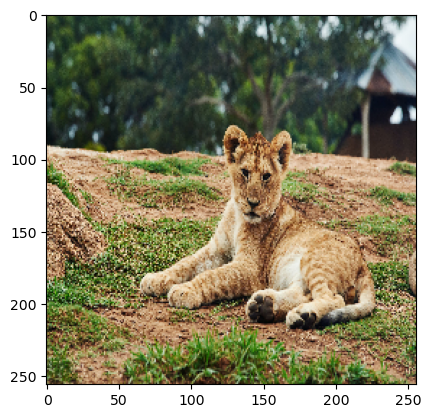

In [38]:
test_img_3 = keras.preprocessing.image.load_img("tiger_cub_test.jpg", target_size=(256, 256))
plt.imshow(test_img_3)
plt.show()

In [41]:
# Preprocess data
img_tensor_3 = np.expand_dims(keras.preprocessing.image.img_to_array(test_img_3),axis=0)/255.

# Feed into activation model to get an activation value
prediction_model_3 = models.load_model('pretrained_vgg16_10.h5')
prediction_3 = prediction_model_3.predict(img_tensor_3)
c_d_test.class_names[np.argmax(prediction_3)]

'dog'